In [1]:
%load_ext autoreload
%autoreload 2

import pygplates
import numpy as np
import pygmt
import xarray as xr
from gprm.datasets import Reconstructions
from gprm import ReconstructionModel, PointDistributionOnSphere
from gprm.datasets import Seafloor
from gprm.utils.create_gpml import gpml2gdf
import seaborn as sns

import sys
sys.path.append('../')
import helper_functions as hf


In [2]:
#Mu2016 = Reconstructions.fetch_Muller2016()
M2016 = Reconstructions.fetch_Matthews2016()
M2021 = Reconstructions.fetch_Merdith2021()
M2019 = Reconstructions.fetch_Muller2019()
C2020 = Reconstructions.fetch_Clennett()


perspective = None

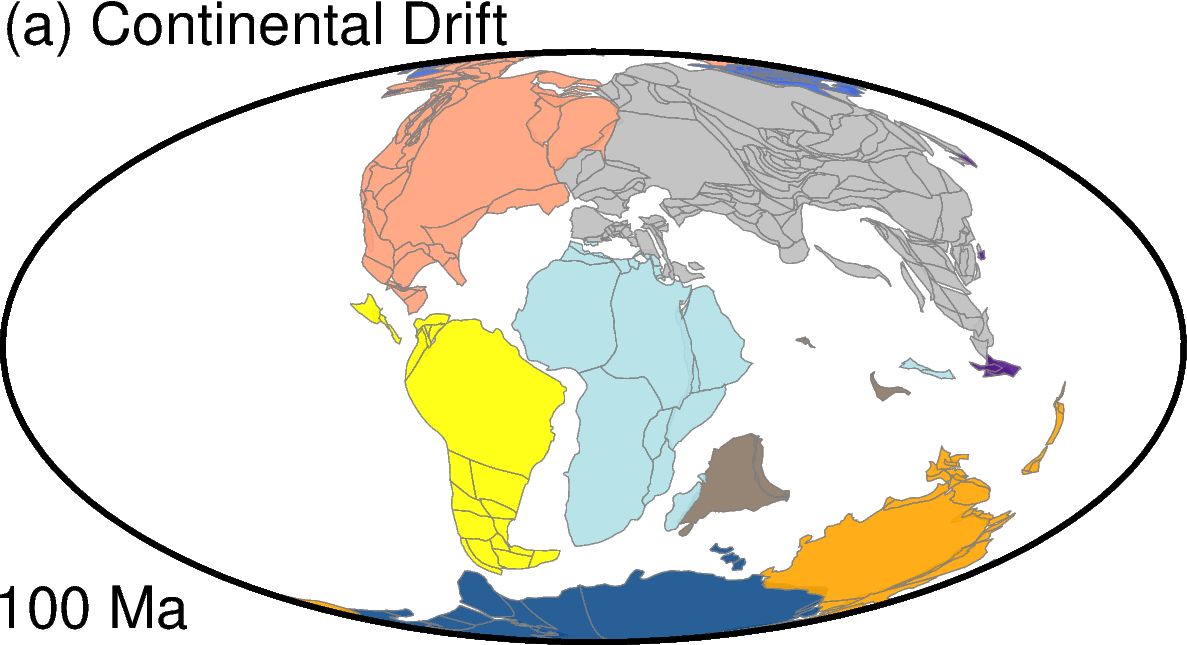

In [3]:
region='d'

def continental_drift(fig, reconstruction_model, reconstruction_time,
                      region='d', projection='Q0/37.5/10c'):

    #region='d'
    #projection='Q120/37.5/10c'
    reconstructed_continents = reconstruction_model.polygon_snapshot('continents', reconstruction_time)
    reconstructed_plates = reconstruction_model.plate_snapshot(reconstruction_time)

    plate_partitioner = pygplates.PlatePartitioner(reconstructed_plates.resolved_topologies, M2016.rotation_model)
    for p in reconstructed_continents.reconstructed_polygons:
        result = plate_partitioner.partition_point(p.get_reconstructed_geometry().get_interior_centroid())
        p.get_feature().set_reconstruction_plate_id(result.get_resolved_feature().get_reconstruction_plate_id()) #, verify_information_model=pygplates.VerifyInformationModel.no)
    

    fig.basemap(region=region, projection=projection, frame='lrtb', perspective=perspective)

    pygmt.makecpt(cmap='gray', series=[0,200000,20000])

    reconstructed_continents.plot(fig, color='+z', cmap='./plate_id_regular.cpt',
                                  aspatial='Z=PLATEID1', pen='0.2p,grey50',
                                  transparency=10, perspective=perspective, region=region, projection=projection)

    fig.text(x=0.0,y=1.05,text='(a) Continental Drift', justify='LM',
                 region='0/1/0/1', projection='x5c', font='14p', no_clip=True)
    fig.text(x=0.15,y=0.06,text='{:0.0f} Ma'.format(reconstruction_time),
                 region='0/1/0/1', projection='x5c', font='14p', no_clip=True)
    
    fig.basemap(region=region, projection=projection, frame='lrtb', perspective=perspective)


    
M2016 = Reconstructions.fetch_Matthews2016()

fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
continental_drift(fig, M2016, reconstruction_time=100, projection='W10c')#, projection='Q0/37.5/10c')
#fig.savefig('./figures/continental_drift.pdf')
fig.show(width=800)


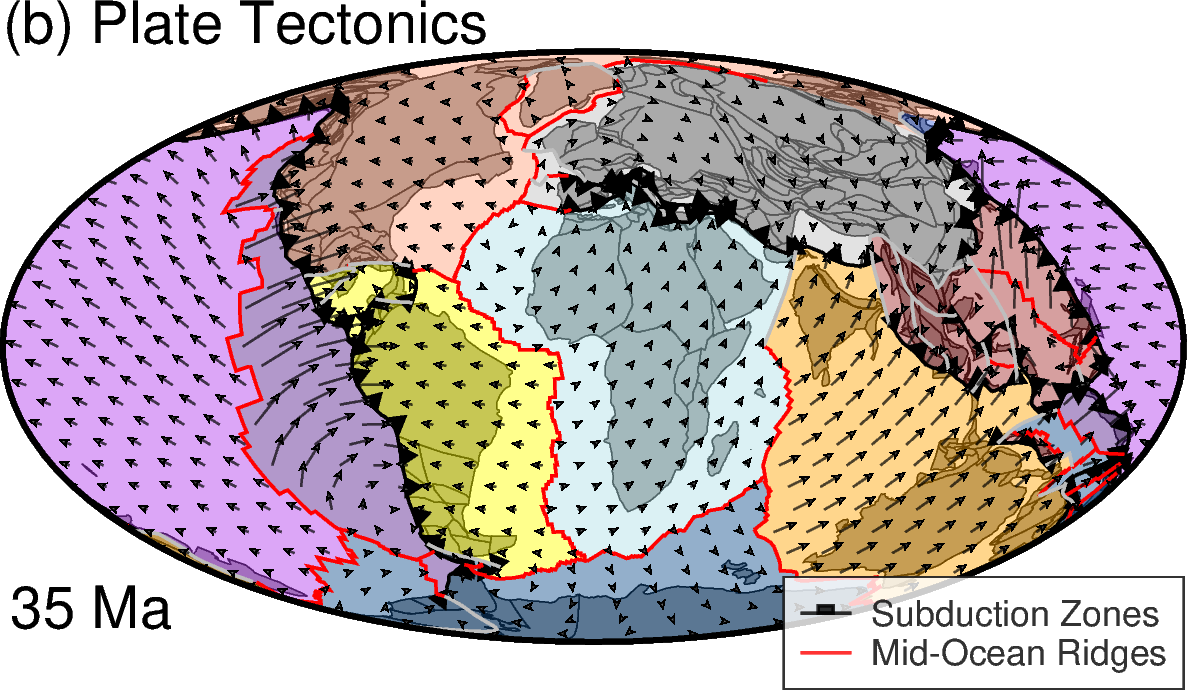

In [4]:

def topological_model(fig, reconstruction_model, reconstruction_time,
                      region='d', projection='Q0/37.5/10c'):
    
    reconstructed_continents = reconstruction_model.polygon_snapshot('continents', reconstruction_time)
    reconstructed_plates = reconstruction_model.plate_snapshot(reconstruction_time)

    velocity_domain = PointDistributionOnSphere(distribution_type='healpix', N=8)
    velocity_field = reconstructed_plates.velocity_field(velocity_domain_features=[velocity_domain.meshnode_feature])

    fig.basemap(region='d', projection=projection, frame='lrtb', perspective=perspective)
    
    reconstructed_continents.plot(fig, color='gray60', perspective=perspective, region='d', projection=projection)

    #colors = sns.color_palette(None, reconstructed_plates.plate_count)   
    #pygmt.makecpt(cmap=','.join(['{:d}/{:d}/{:d}'.format(int(color[0]*255),int(color[1]*255),int(color[2]*255)) for color in colors]), 
    #              series=[0,reconstructed_plates.plate_count,1], categorical=True)
    reconstructed_plates.plot_polygons(fig, color='+z', cmap='./plate_id_regular.cpt',#cmap=True, reduce_plate_ids=True,
                                       aspatial='Z=PLATEID1', close=True,
                                       transparency=55, perspective=perspective, region=region, projection=projection)
    
    reconstructed_plates.plot_subduction_zones(fig, pen='0.75p,black', gap=8, size=4, perspective=perspective, region='d', projection=projection, label='Subduction Zones')
    reconstructed_plates.plot_mid_ocean_ridges(fig, pen='0.75p,red', perspective=perspective, region='d', projection=projection, label='Mid-Ocean Ridges')
    reconstructed_plates.plot_other_boundaries(fig, pen='0.75p,gray', perspective=perspective, region='d', projection=projection)
    velocity_field.plot(fig, style='V0.08c+e+a45+ggray40+n', scaling=300., pen="0.5p,black", color="gray", 
                        transparency=30, perspective=perspective, region='d', projection=projection)

    fig.basemap(region=region, projection=projection, frame='lrtb', perspective=perspective)
    
    #fig.legend(transparency=20, position='JBR+jBR+o-1.5c/-0.4c', box='+gwhite+p0.5p')
    fig.legend(transparency=20, position='JBR+jBR+o0.0c/-0.4c', box='+gwhite+p0.4p')

    fig.text(x=0.0,y=1.05,text='(b) Plate Tectonics', justify='LM',
                 region='0/1/0/1', projection='x5c', font='14p', no_clip=True)
    fig.text(x=0.15,y=0.06,text='{:0.0f} Ma'.format(reconstruction_time),
                 region='0/1/0/1', projection='x5c', font='14p', no_clip=True)
    


fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
topological_model(fig, M2016, reconstruction_time=35, projection='W10c')
fig.savefig('plate_tectonics.pdf')
fig.show(width=800)


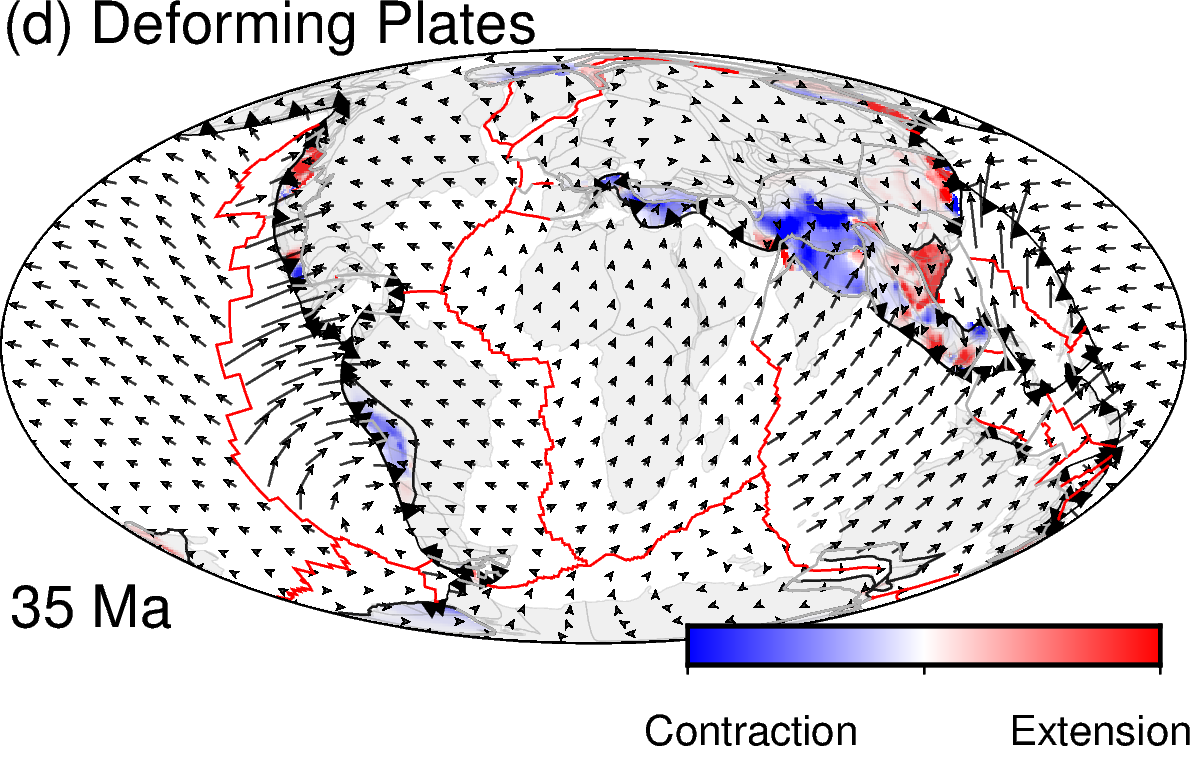

In [5]:

initial_time = 0.
oldest_time = 35.
youngest_time = 0.
#final_time = 0.
reconstruction_time = 35.


def deforming_model(fig, reconstruction_model, reconstruction_time,
                    region='d', projection='Q0/37.5/10c'):
    
    tm = hf.get_topological_model(reconstruction_model)
    
    time_spans = hf.get_time_spans(tm, initial_time, oldest_time, youngest_time)

    crustal_thickness_delta = hf.get_deltas(time_spans, reconstruction_time, delta_time=-1)

    reconstructed_continents = reconstruction_model.polygon_snapshot('continents', reconstruction_time)
    reconstructed_plates = reconstruction_model.plate_snapshot(reconstruction_time)

    velocity_domain = PointDistributionOnSphere(distribution_type='healpix', N=8)
    velocity_field = reconstructed_plates.velocity_field(velocity_domain_features=[velocity_domain.meshnode_feature])


    fig.basemap(region=region, projection=projection, frame='lrtb', perspective=perspective)

    with pygmt.config(COLOR_NAN='white'):
        pygmt.makecpt(cmap='polar', series=[-1000,1000], background='o')
        fig.grdimage(crustal_thickness_delta, 
                    region=region, projection=projection, cmap=True)

    reconstructed_continents.plot(fig, color='gray70', pen='0.2p,gray50', projection=projection,
                                  region=region, perspective=perspective, transparency=80)
    
    velocity_field.plot(fig, scaling=300., pen="0.5p,black", color="dodgerblue", 
                        style='V0.08c+e+a45+ggray40+n', region=region, projection=projection, #V0.15c+e+a45+ggray40+n   #V0.08c+e+gblack+n
                        transparency=20, perspective=perspective)
    reconstructed_plates.plot_deformation_zones(fig, color='-', region=region, projection=projection, 
                                                perspective=perspective)
    reconstructed_plates.plot_subduction_zones(fig, region=region, projection=projection, 
                                               perspective=perspective)
    reconstructed_plates.plot_mid_ocean_ridges(fig, region=region, projection=projection, 
                                               perspective=perspective)
    reconstructed_plates.plot_other_boundaries(fig, region=region, projection=projection, 
                                               perspective=perspective)
    
    with pygmt.config(FONT_ANNOT_PRIMARY='1p,white', FONT_LABEL='10p', MAP_TICK_LENGTH_PRIMARY='2p', MAP_FRAME_PEN='1p,black'):
        fig.colorbar(position='JBR+jBR+o0.2c/-0.2c+w4.0c/0.33c+h', frame=['+n','xa1000+lContraction             Extension '])

    fig.text(x=0.0,y=1.05,text='(d) Deforming Plates', justify='LM',
                 region='0/1/0/1', projection='x5c', font='14p', no_clip=True)
    fig.text(x=0.15,y=0.06,text='{:0.0f} Ma'.format(reconstruction_time),
                 region='0/1/0/1', projection='x5c', font='14p', no_clip=True)

fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
deforming_model(fig, M2019, reconstruction_time, projection='W10c')
fig.savefig('./deforming_plates.pdf')
fig.show(width=800)


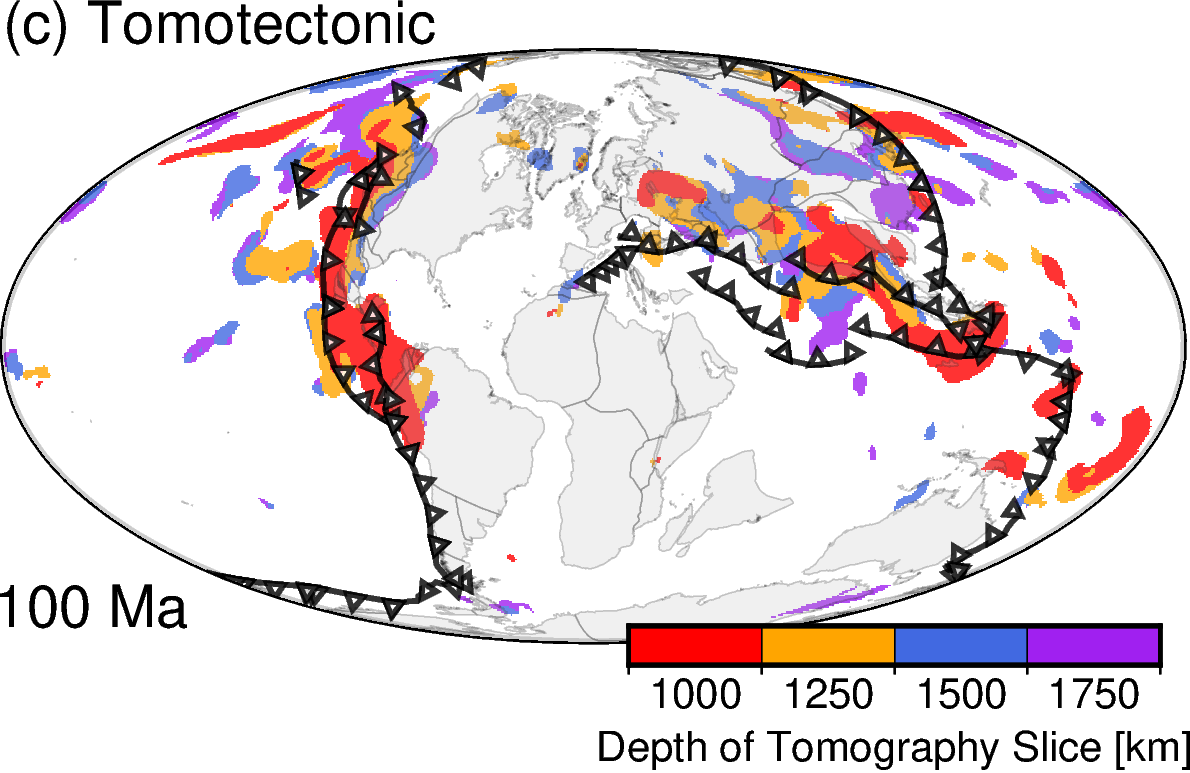

In [6]:
def add_votemap(fig, depth, cmapstring, projection, region):
    min_votes = 8
    votemap = pygmt.xyz2grd('/Users/simon/Data/SeismicTomography/votemaps_allP_20220809/SubMachine_votemap_depth_slice_{:0.0f}.txt'.format(depth),
                            region='d', spacing='0.5d')
    votemap_filt = pygmt.grdfilter(grid=votemap, distance=2, filter='g500', coltypes='g')
    votemap_filt.data[votemap_filt.data<(min_votes+0.1)] = np.nan
    pygmt.makecpt(cmap=cmapstring, series=[min_votes,20,4], no_bg=True)
    fig.grdimage(grid=votemap_filt, 
                 transparency=10, region=region, projection=projection, cmap=True, nan_transparent=True)


def load_votemap(depth, min_votes = 8):
    votemap = pygmt.xyz2grd('/Users/simon/Data/SeismicTomography/votemaps_allP_20220809/SubMachine_votemap_depth_slice_{:0.0f}.txt'.format(depth),
                                 region='d', spacing='0.5d')
    votemap_filt = pygmt.grdfilter(grid=votemap, distance=2, filter='g500', coltypes='g')
    votemap_filt.data[votemap_filt.data<(min_votes+0.1)] = np.nan
    
    return votemap_filt
    
    
    
def tomotectonic_model(fig, reconstruction_model, reconstruction_time,
                       region='d', projection='Q0/37.5/10c'):

    fig.basemap(projection=projection, region=region, perspective=perspective, frame='lrtb')

    depth = 1750
    votemap_filt = load_votemap(depth, min_votes = 8)
    votemap_base = votemap_filt.copy()
    votemap_base.data[~np.isnan(votemap_filt.data)] = depth

    for depth in [1500, 1250, 1000]:
        votemap_filt = load_votemap(depth, min_votes = 8)
        votemap_base.data[~np.isnan(votemap_filt.data)] = depth
       
    votemap_base.to_netcdf('tmp.nc')
    with pygmt.config(COLOR_NAN='white'):
        pygmt.makecpt(cmap='red,orange,royalblue,purple', series=[875,1875,250], overrule_bg=True)
        fig.grdimage(grid='tmp.nc', 
                     transparency=20, region=region, projection=projection, cmap=True)

    #'''
    reconstruction_model.polygon_snapshot('coastlines', reconstruction_time).plot(fig, color='gray70', 
                                                                                  transparency=80,
                                                                                  projection=projection, region=region, 
                                                                                  perspective=perspective)
    reconstruction_model.plate_snapshot(
        reconstruction_time).plot_subduction_zones(fig, pen='1.25p,black', gap=9, size=4, color='white', transparency=20,
                                                   projection=projection, region=region, perspective=perspective)

    pygmt.makecpt(categorical=True, cmap='red,orange,royalblue,purple', color_model='+c1000,1250,1500,1750')
    #pygmt.makecpt(categorical=True, cmap='lightblue,royalblue,blue3,darkblue', color_model='+c1000,1250,1500,1750', no_bg=True)
    with pygmt.config(FONT_ANNOT_PRIMARY='9p,white', FONT_LABEL='10p', MAP_TICK_LENGTH_PRIMARY='2p', MAP_FRAME_PEN='1p,black'):
        fig.colorbar(position='JBR+jBR+o0.2c/-0.2c+w4.5c/0.33c+h', frame=['+n','xa1+lDepth of Tomography Slice [km]'])
    with pygmt.config(FONT_LABEL='10p', MAP_TICK_LENGTH_PRIMARY='2p', MAP_FRAME_PEN='1p,black'):
        fig.colorbar(position='JBR+jBR+o0.2c/-0.2c+w4.5c/0.33c+h')
        
    fig.text(x=0.0,y=1.05,text='(c) Tomotectonic', justify='LM',
                 region='0/1/0/1', projection='x5c', font='14p', no_clip=True)
    fig.text(x=0.15,y=0.06,text='{:0.0f} Ma'.format(reconstruction_time),
                 region='0/1/0/1', projection='x5c', font='14p', no_clip=True)
    #'''


fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
tomotectonic_model(fig, C2020, reconstruction_time=100, projection='W10c')
fig.savefig('./tomotectonics_alt.jpg')
fig.show(width=800)



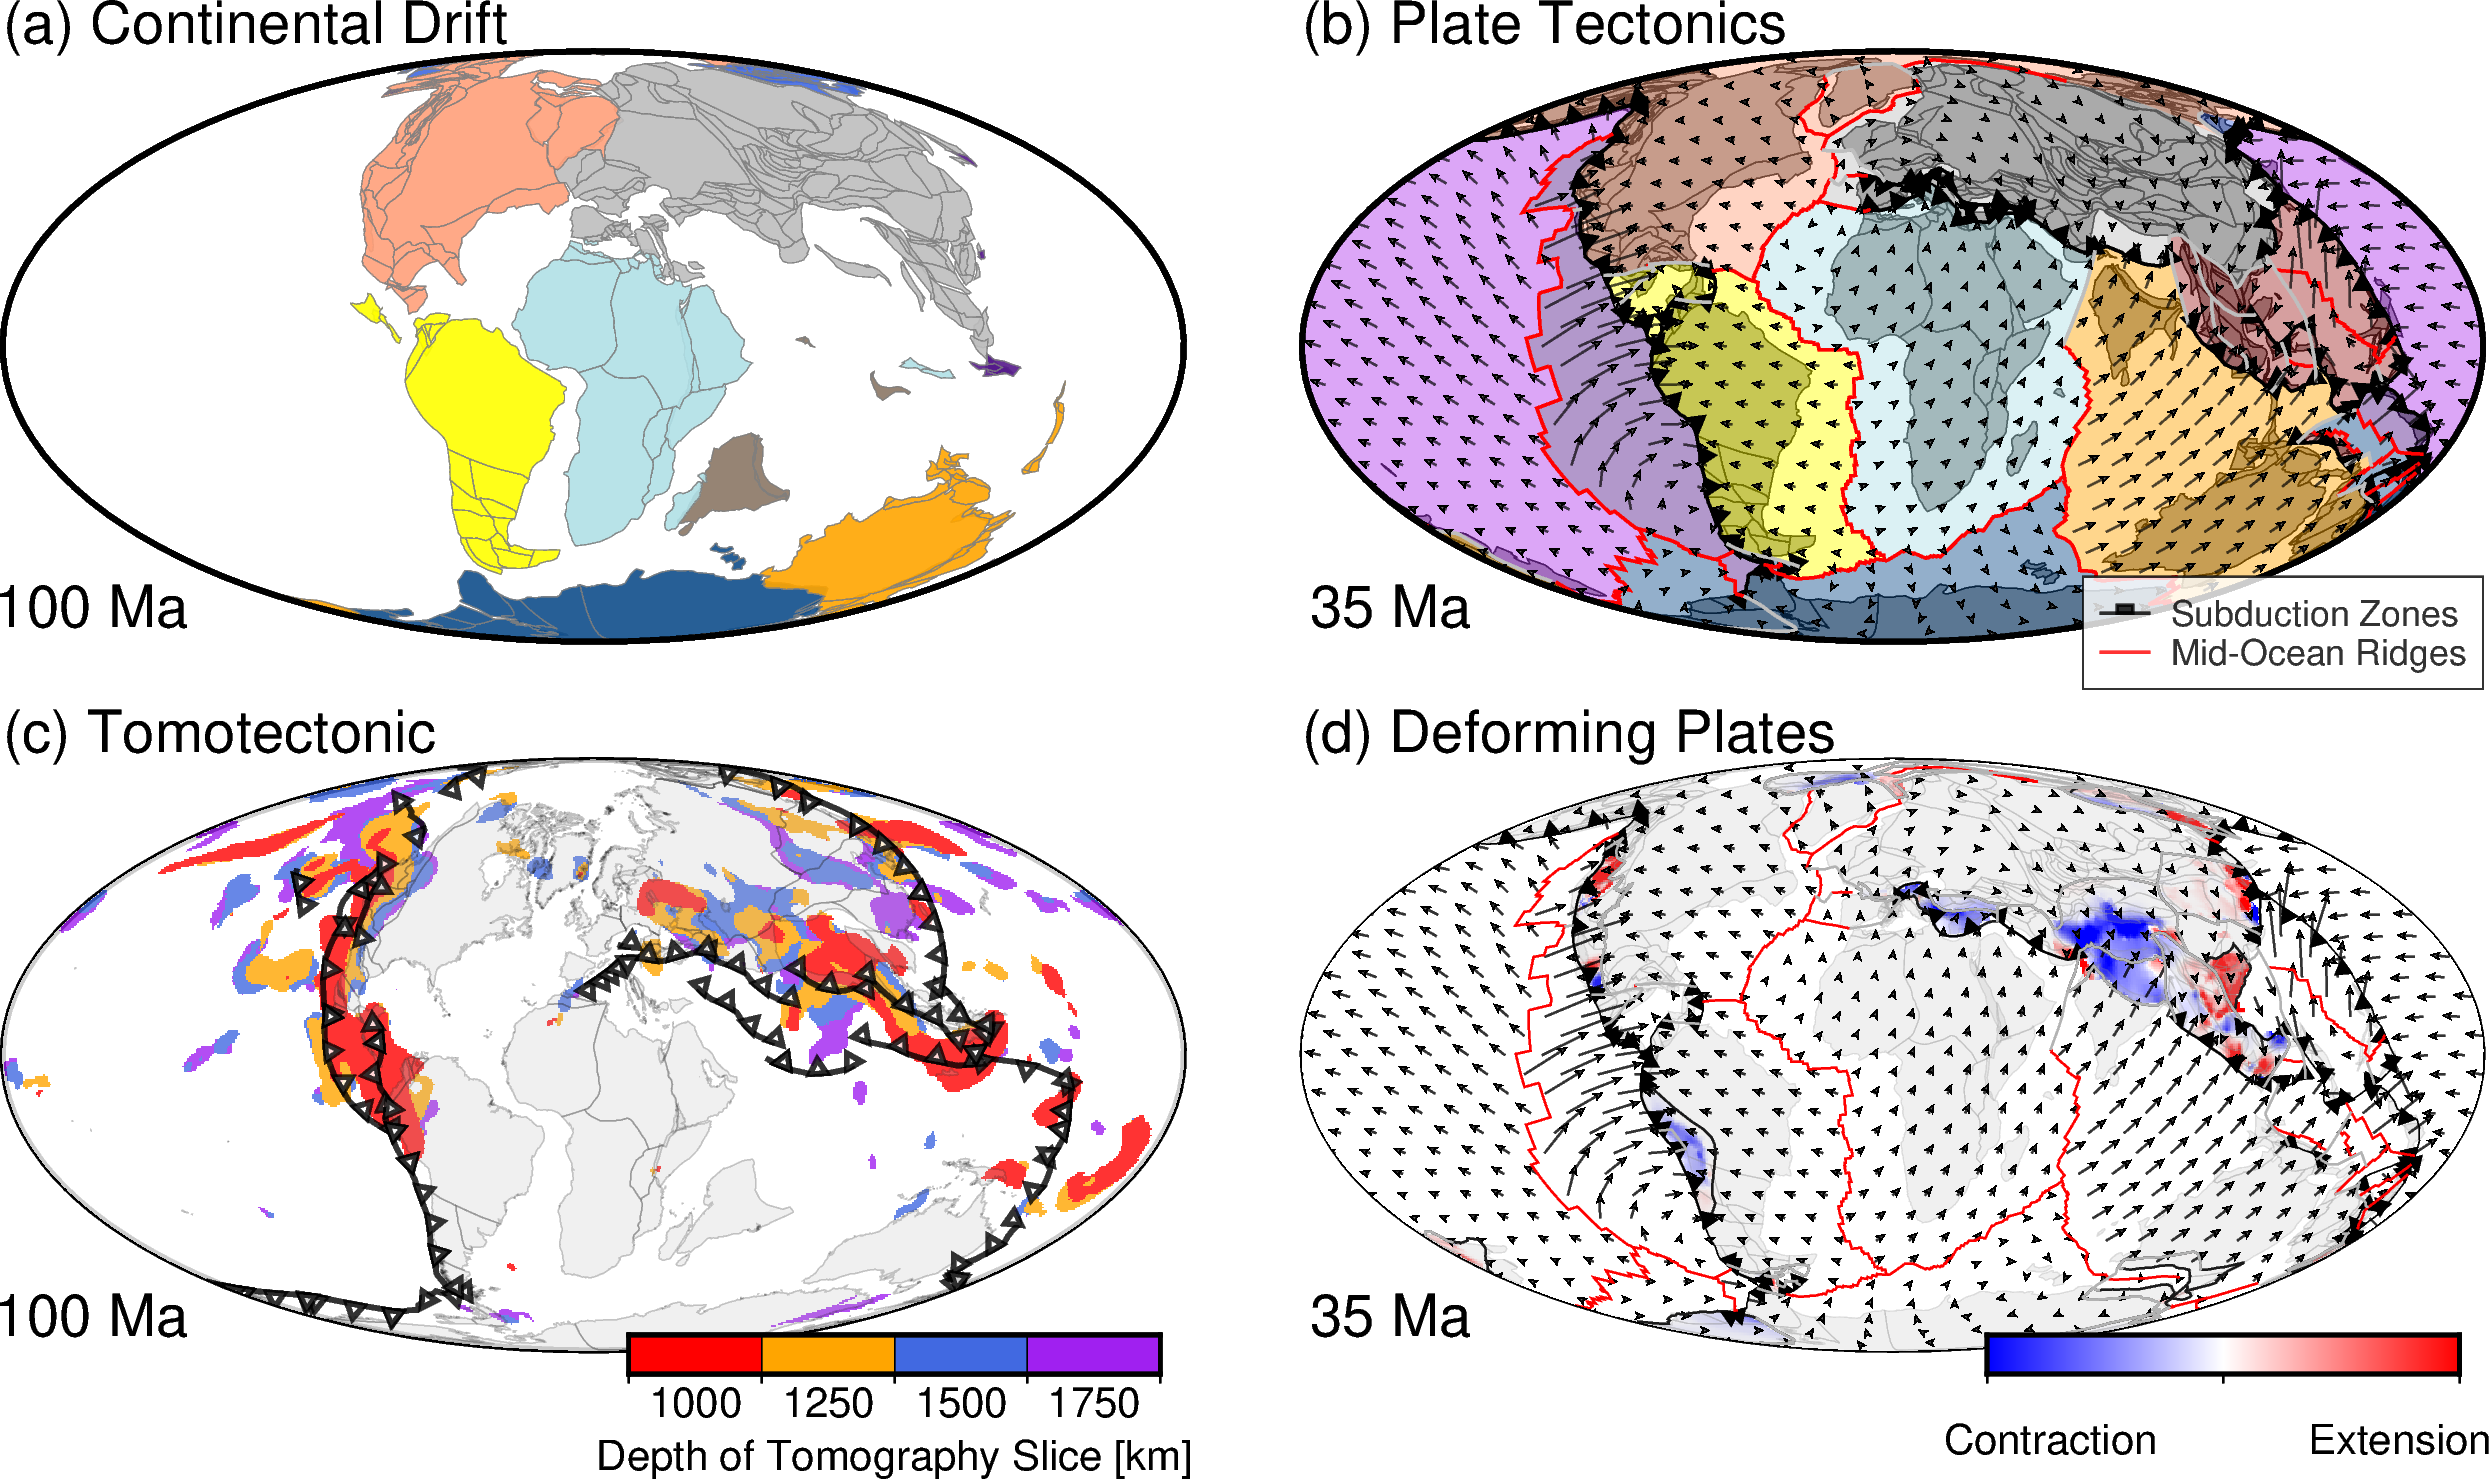

In [7]:
M2016 = Reconstructions.fetch_Matthews2016()
M2019 = Reconstructions.fetch_Muller2019()
C2020 = Reconstructions.fetch_Clennett()

projection = 'W10c'

fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")

continental_drift(fig, M2016, reconstruction_time=100, projection=projection)
fig.shift_origin(xshift='11c')
topological_model(fig, M2016, reconstruction_time=35, projection=projection)
fig.shift_origin(xshift='-11c', yshift='-6c')
tomotectonic_model(fig, C2020, reconstruction_time=100, projection=projection)
fig.shift_origin(xshift='11c')
deforming_model(fig, M2019, reconstruction_time=35, projection=projection)

fig.savefig('Figure3.pdf', dpi=300)
fig.show(width=1200)
